In [1]:
import os
import time
import glob
import LatLon 
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime
from matplotlib.dates import date2num
pd.set_option('display.max_rows', 10)

%matplotlib inline
import pylab
import geoplotlib
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits import basemap
from pysurvey.plot import setup, legend, icolorbar, density, text
from sklearn import cluster

In [2]:
shipdata = pd.read_csv('/Users/ajmendez/tmp/ships/climate-data-from-ocean-ships/CLIWOC15.csv')
# wdf = wdf[wdf.Lon3.notnull() & wdf.Lat3.notnull()]
print shipdata.columns.tolist()

['RecID', 'InstAbbr', 'InstName', 'InstPlace', 'InstLand', 'NumberEntry', 'NameArchiveSet', 'ArchivePart', 'Specification', 'LogbookIdent', 'LogbookLanguage', 'EnteredBy', 'DASnumber', 'ImageNumber', 'VoyageFrom', 'VoyageTo', 'ShipName', 'ShipType', 'Company', 'OtherShipInformation', 'Nationality', 'Name1', 'Rank1', 'Name2', 'Rank2', 'Name3', 'Rank3', 'ZeroMeridian', 'StartDay', 'TimeGen', 'ObsGen', 'ReferenceCourse', 'ReferenceWindDirection', 'DistUnits', 'DistToLandmarkUnits', 'DistTravelledUnits', 'LongitudeUnits', 'VoyageIni', 'UnitsOfMeasurement', 'Calendar', 'Year', 'Month', 'Day', 'DayOfTheWeek', 'PartDay', 'TimeOB', 'Watch', 'Glasses', 'UTC', 'CMG', 'ShipSpeed', 'Distance', 'drLatDeg', 'drLatMin', 'drLatSec', 'drLatHem', 'drLongDeg', 'drLongMin', 'drLongSec', 'drLongHem', 'LatDeg', 'LatMin', 'LatSec', 'LatHem', 'LongDeg', 'LongMin', 'LongSec', 'LongHem', 'Lat3', 'Lon3', 'LatInd', 'LonInd', 'PosCoastal', 'EncName', 'EncNat', 'EncRem', 'Anchored', 'AnchorPlace', 'LMname1', 'LMdir

/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (5,6,7,8,11,13,18,19,23,24,25,26,28,29,30,34,35,38,43,44,46,73,77,81,82,84,85,87,88,94,96,97,98,99,111,114,116,119,120,122,124,125,127,129,131,133,135,137,140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Cleaned up version
filename = '/Users/ajmendez/tmp/ships/ships_clean.csv'
# shipdata.to_csv(filename)
shipdata = pd.read_csv(filename)

/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6,7,8,9,12,14,19,20,24,25,26,27,29,30,31,35,36,39,44,45,47,74,78,82,83,85,86,88,89,95,97,98,99,100,112,115,117,120,121,123,125,126,128,130,132,134,136,138,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up Nationality

In [4]:
shipdata['nat'] = shipdata['Nationality'].replace('British ', 'British')
print np.unique(shipdata['nat'])

['American' 'British' 'Danish' 'Dutch' 'French' 'Hamburg' 'Spanish'
 'Swedish']


## Clean up From / To

In [5]:
def clean(x):
    x = x.decode('ascii','replace').strip().lower().split('(')[0].split(',')[0].strip()
    x = x.replace('roads', '').replace('road', '').replace(' uk', '').replace('.', '').replace("'",'').strip()
    return x.encode('ascii', 'replace')
shipdata['from'] = shipdata['VoyageFrom'].astype('str').map(clean)
shipdata['to'] = shipdata['VoyageTo'].astype('str').map(clean)
np.unique(shipdata['from']).shape, np.unique(shipdata['to']).shape

((864,), (900,))

In [6]:
def get_named():
    lat, lon, name, number  = [], [], [], []
    items = ['from', 'to']
    for item in items:
        arr = shipdata[item]
        ind = 0 if (item == 'from') else -1
        for n in np.unique(arr):
            tmp = shipdata[(arr == n) &
                           shipdata['Lat3'].notnull() & 
                           shipdata['Lon3'].notnull()].sort_values(by='datenum')
            if len(tmp) > 10:
                lat.append(tmp['Lat3'].iloc[ind])
                lon.append(tmp['Lon3'].iloc[ind])
                name.append(n)
                number.append(len(tmp))
    return pd.DataFrame.from_items(dict(lat=lat, lon=lon, number=number, name=name).iteritems())

named_places = get_named()
print named_places.shape, np.unique(named_places['name']).shape

(1449, 4) (1035,)


In [ ]:
# Spukhafte fernwirkung

In [17]:
def get_cluster(bandwidth=0.1):
    places = named_places.copy()
#     print cluster.estimate_bandwidth(named_places[['lon','lat']].as_matrix(), quantile=0.01)
    ms = cluster.MeanShift(bandwidth=bandwidth)
    ms.fit(places[['lon','lat']])

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print 'Found: {:,d} groups'.format(n_clusters_)
    
    for k, label in enumerate(labels_unique):
        isgood = (labels == label)
        
        best_label = places.loc[isgood, ['name','number']].sort_values(by='number')['name'].iloc[-1]
        places.loc[isgood, 'label'] = best_label
        
        center = cluster_centers[k]
        places.loc[isgood, 'clon'] = center[0]
        places.loc[isgood, 'clat'] = center[1]
        
    return ms, places

# large bandwidth to simplify things
ms, meanshift_places = get_cluster(10.0)
    

Found: 55 groups


In [18]:
def map_clusters(places, arrname):
    arr = shipdata[arrname]
    uname = np.unique(arr)
    for name in uname:
        tmp = places[places['name'] == name]
        if len(tmp) <= 1:
            continue
        tmp = tmp.iloc[0]
#         assert len(tmp) == 1, IndexError('Found multiple: {}\n {}'.format(name, tmp))
        isname = (arr == name)
        shipdata.loc[isname, arrname+'_label'] = tmp['label']
        shipdata.loc[isname, arrname+'_lon'] = tmp['clon']
        shipdata.loc[isname, arrname+'_lat'] = tmp['clat']

    
map_clusters(meanshift_places, 'from')
map_clusters(meanshift_places, 'to')

In [9]:
shipdata['lon'] = shipdata['Lon3'].fillna(-180)
shipdata['lat'] = shipdata['Lat3'].fillna(-90)

In [4]:
def nicedatetime(*args, **kwargs):
    try:
        return datetime(*args, **kwargs)
    except Exception as e:
        if args[2] in [31,29]:
            print args
            return datetime(args[0], args[1], args[2]-1)
        print args
        raise
shipdata['date'] = map(nicedatetime, shipdata['Year'], shipdata['Month'], shipdata['Day'])
shipdata['datenum'] = shipdata['date'].apply(date2num)

(1764, 9, 31)
(1788, 6, 31)
(1841, 6, 31)
(1850, 11, 31)
(1773, 2, 29)
(1794, 6, 31)
(1845, 9, 31)
(1769, 2, 29)
(1774, 9, 31)
(1779, 6, 31)


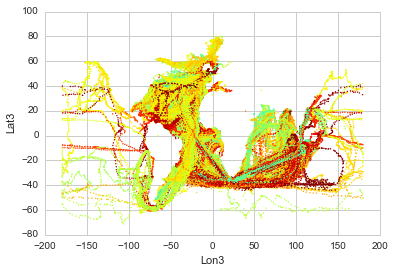

In [6]:
shipdata.plot('Lon3', 'Lat3', c='Year', kind='scatter', 
              lw=0, cmap=pylab.cm.jet, s=2, colorbar=False)

In [377]:
lon = np.array(shipdata['Lon3'])
lat = np.array(shipdata['Lat3'])
c = np.array(shipdata['Year'])
vmin, vmax = np.percentile(c, (5,95))

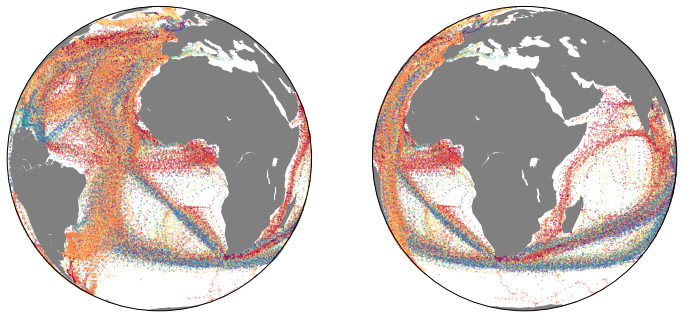

In [41]:
pylab.figure(figsize=(12,6))
pylab.subplot(121)
m = basemap.Basemap(lon_0=-10, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)

pylab.subplot(122)
m = basemap.Basemap(lon_0=30, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)

# m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
None

<matplotlib.colorbar.Colorbar instance at 0x1636233b0>

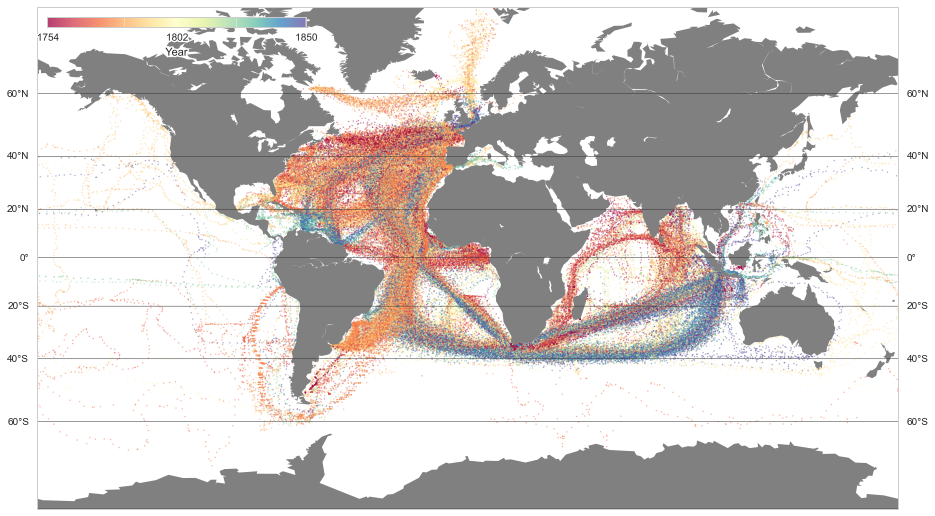

In [87]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)
icolorbar(sca)

In [75]:
x,y = np.linspace(-180,180,361), np.linspace(-80,80,161)
X,Y = np.meshgrid(x,y)
Z = np.histogram2d(lon, lat, bins=(x,y))[0]
Z = np.ma.MaskedArray(np.log10(Z), Z==0)
# X,Y = np.meshgrid(X,Y)

<matplotlib.colorbar.Colorbar instance at 0x15d5e5a70>

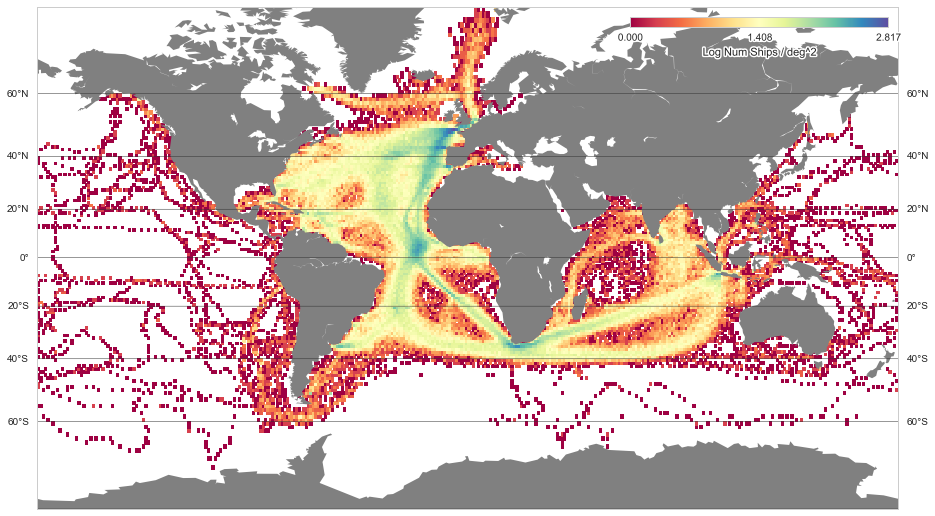

In [88]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80, projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.fillcontinents(color='0.8')
# m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

mx, my = m(X,Y)
pcm = m.pcolormesh(mx,my, Z.T, label='Log Num Ships / deg^2',
                   cmap=pylab.cm.Spectral)
icolorbar(pcm, loc=1)

In [20]:
tmp = shipdata[shipdata['Lon3'].notnull() & shipdata['Lat3'].notnull()]
tmp = pd.DataFrame(np.vstack([tmp['Lat3'], tmp['Lon3']]).T, columns=['lat','lon'])

In [28]:
# geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
geoplotlib.kde(tmp, 2, alpha=128)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.WORLD)
geoplotlib.inline(800)

('smallest non-zero count', 4.4777898101688105e-09)
('max count:', 42.119397791020972)


In [15]:
def latlon_distance(a,b):
    A = LatLon.LatLon(*a)
    B = LatLon.LatLon(*b)
    try:
        return A.distance(B) # in km
    except:
        print a,b
        raise

tmp = shipdata[shipdata['datenum'] == 657193]
metrics.pairwise_distances(tmp[['lat', 'lon']], metric=latlon_distance)

array([[     0.        ,   4920.69610004,   9767.54719063,  13274.04834131],
       [  4920.69610004,      0.        ,   5587.38056592,   8407.40511157],
       [  9767.54719063,   5587.38056592,      0.        ,   4054.37403477],
       [ 13274.04834131,   8407.40511157,   4054.37403477,      0.        ]])

In [50]:
shipdata.loc[:, 'mindistance'] = 0
shipdata.loc[:, 'meandistance'] = 0
shipdata.loc[:, 'maxdistance'] = 0
udate = np.unique(shipdata['datenum'])
for ud in udate:
    isdate = (shipdata['datenum'] == ud) & (shipdata['Lat3'].notnull()) & (shipdata['Lon3'].notnull())
    tmp = shipdata.loc[isdate, ['lat', 'lon']]
    if len(tmp) > 1:
#         distance = metrics.euclidean_distances(tmp)
        distance = metrics.pairwise_distances(tmp, metric=latlon_distance)
        d = distance[distance>0]
        if len(d) > 0:
            shipdata.loc[isdate, 'mindistance'] = d.min()
            shipdata.loc[isdate, 'meandistance'] = d.mean()
            shipdata.loc[isdate, 'maxdistance'] = d.max()
#         if distance.max() > 0:
#             print distance
#             print tmp

In [52]:
shipdata[['datenum','mindistance', 'meandistance', 'maxdistance']].describe()

,datenum,mindistance,meandistance,maxdistance
count,280280.000000,280280.000000,280280.000000,280280.000000
mean,656916.625467,768.855541,5831.724525,12150.396105
std,11675.639825,1455.094317,2749.545893,5464.749518
min,606956.000000,0.000000,0.000000,0.000000
25%,647883.000000,21.393418,4545.631782,10058.556312
50%,654155.000000,268.437644,6399.604535,13554.701941
75%,668905.000000,897.473756,7714.422799,16033.725351
max,677369.000000,18357.244870,18357.244870,19991.480800


In [ ]:
pd.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138a5fc10>]], dtype=object)

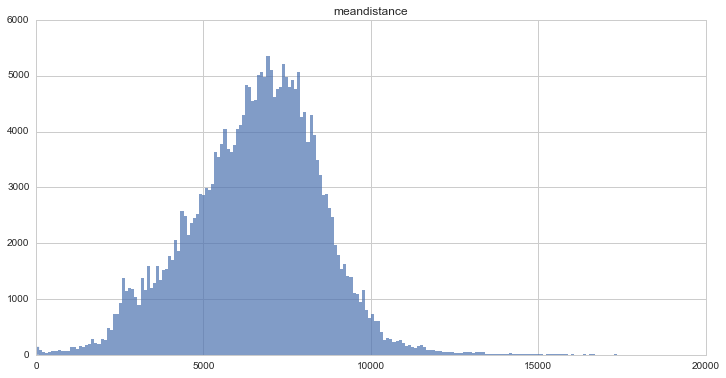

In [57]:
shipdata[shipdata['meandistance']>0].hist('meandistance', bins=200, lw=0, alpha=0.7,
                                          figsize=(12,6), )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137d29310>]], dtype=object)

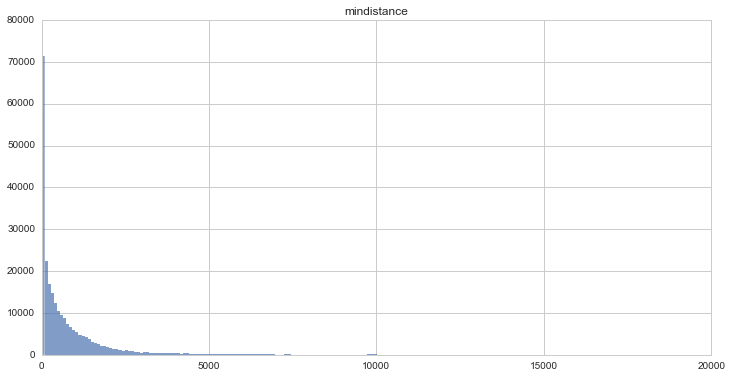

In [68]:
shipdata[shipdata['mindistance']>0].hist('mindistance', bins=200, lw=0, alpha=0.7,
                                          figsize=(12,6), )

10158


<matplotlib.colorbar.Colorbar instance at 0x13c5e9950>

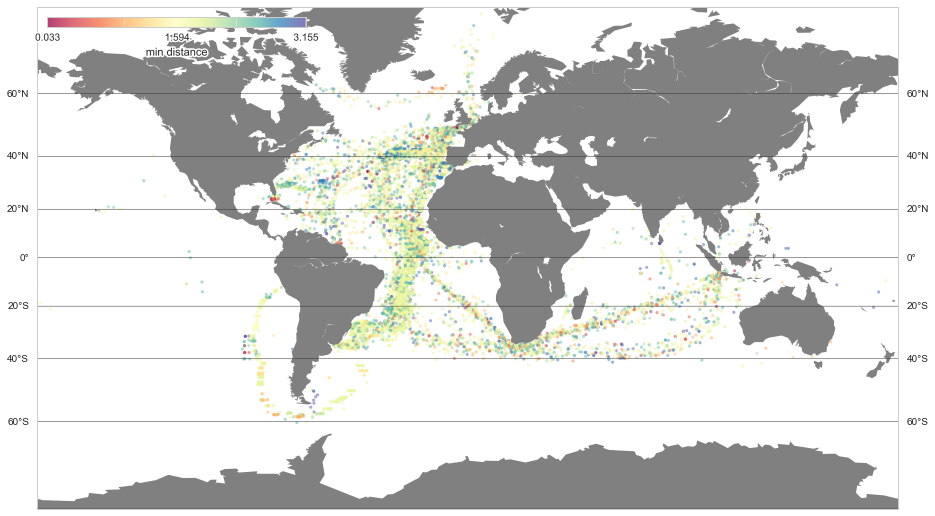

In [63]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
c = np.array(shipdata['mindistance'])
ii = np.where((c > 0) & (c < 1.6*2))[0]
print len(ii)
sca = m.scatter(x[ii], y[ii], c=c[ii], label='min distance',
                cmap=pylab.cm.Spectral,
                s=10, lw=0, alpha=0.5)
icolorbar(sca)

202


<matplotlib.colorbar.Colorbar instance at 0x13d24f440>

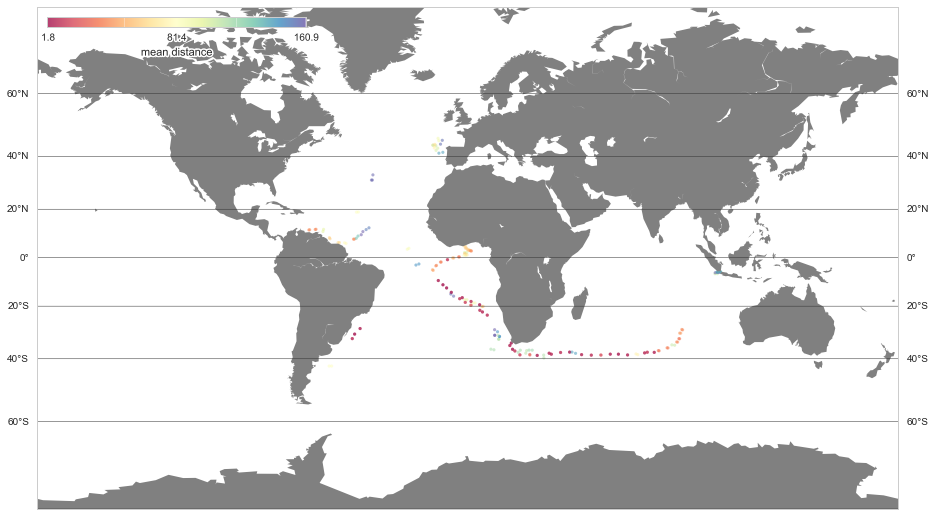

In [67]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
c = np.array(shipdata['meandistance'])
ii = np.where((c > 0) & (c < 160.934))[0]
print len(ii)
sca = m.scatter(x[ii], y[ii], c=c[ii], label='mean distance',
                cmap=pylab.cm.Spectral,
                s=10, lw=0, alpha=0.5)
icolorbar(sca)

In [383]:
np.percentile(c, [5,95])

array([ 1754.,  1850.])

American 200
British 88559
Danish 62
Dutch 125977
French 10632
Hamburg 68
Spanish 54082
Swedish 700


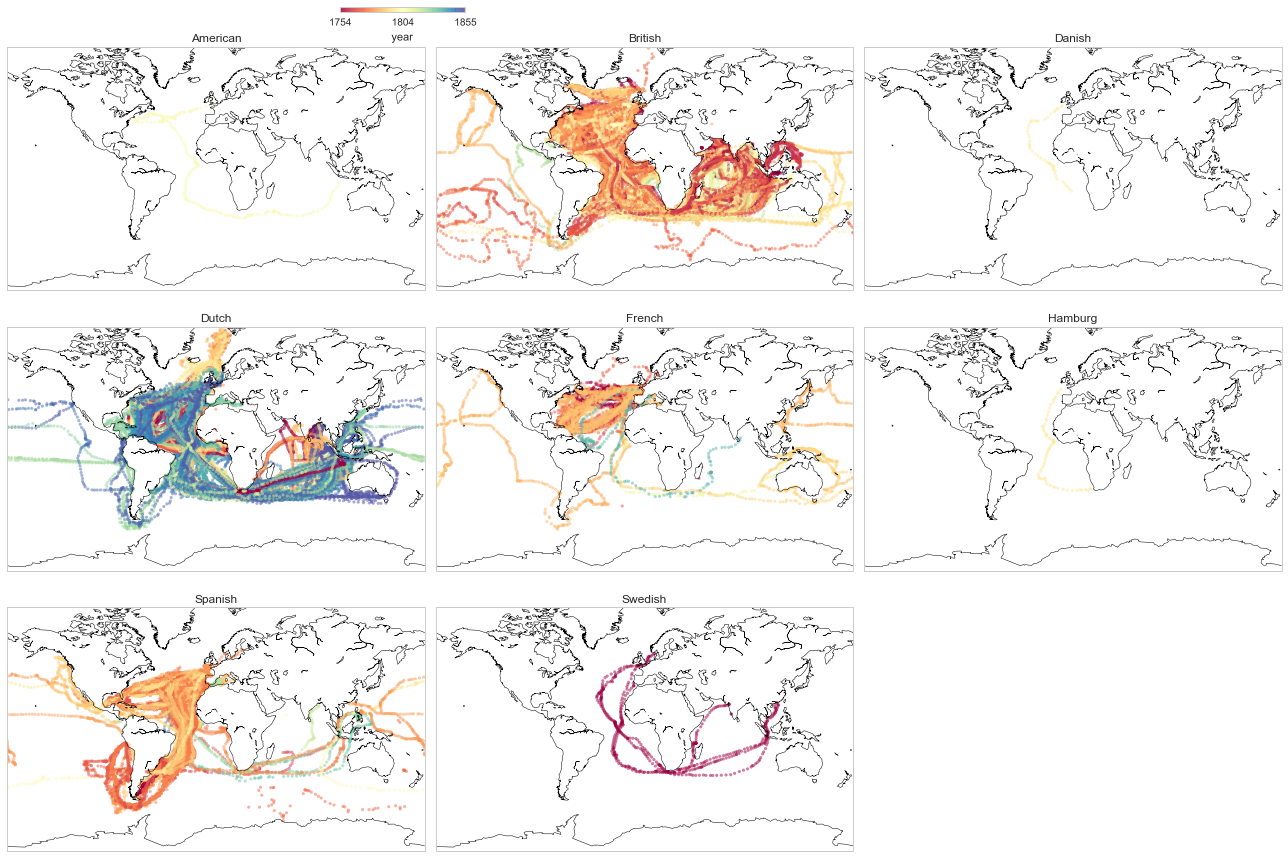

In [388]:
pylab.figure(figsize=(18,12))

x, y = m(lon, lat)
c = np.array(shipdata['Year'])
nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                        urcrnrlon=180, urcrnrlat=80,
                        projection='mill')
#     m.fillcontinents(color='0.5')
    m.drawcoastlines(linewidth=0.5)
#     m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
    
    ii = np.where(nationality == nat)[0]
    print nat, len(ii)
    sca = m.scatter(x[ii], y[ii], c=c[ii], label='{} Year'.format(nat),
                    cmap=pylab.cm.Spectral, vmin=1754, vmax=1855,
                    s=10, lw=0, alpha=0.5)
    if nat == 'American':
        icolorbar(sca, label='year', loc=1, tickfmt='{:0.0f}', borderpad=-4)
#     break
pylab.tight_layout()

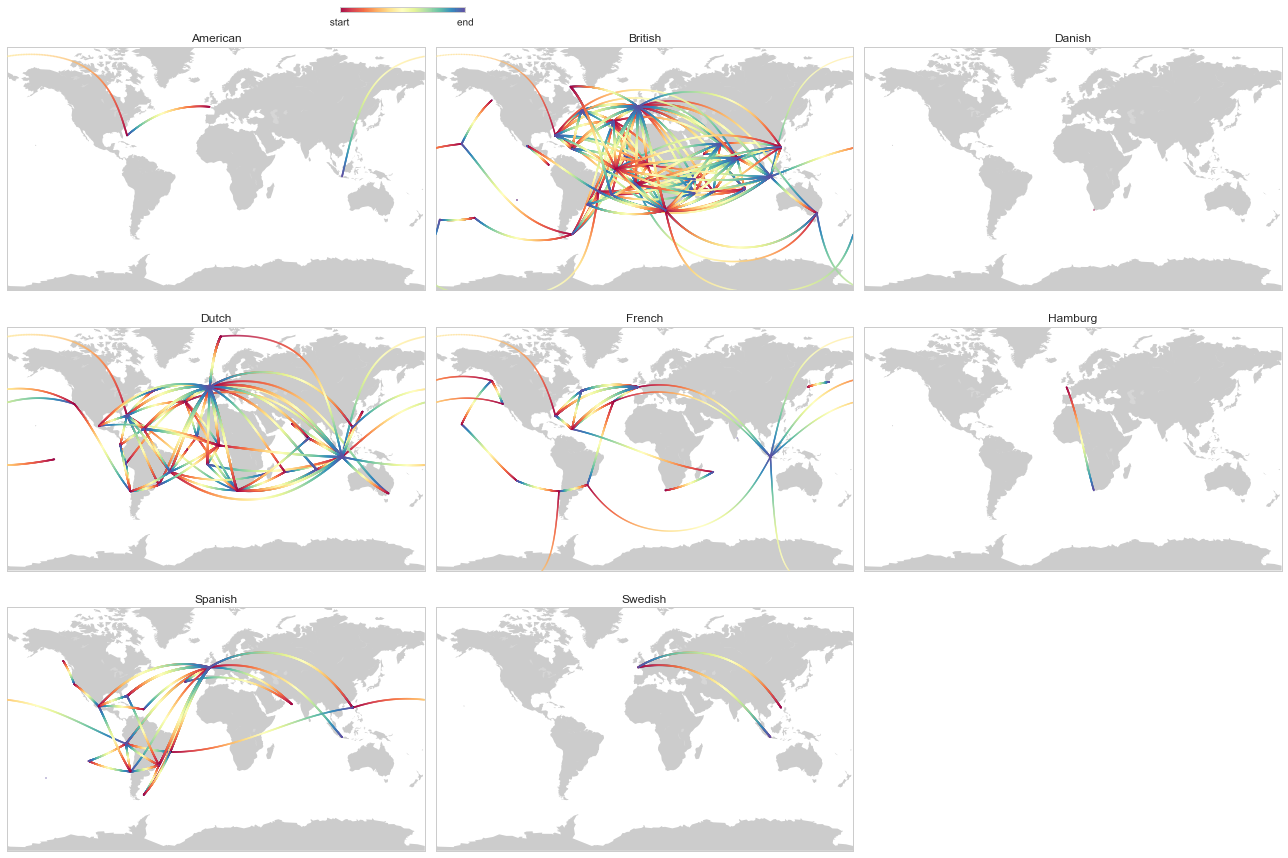

In [20]:
pylab.figure(figsize=(18,12))




ngc = 500

fromarr = shipdata['from_label'].astype('str')
ufrom = np.unique(fromarr)

nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
    m.fillcontinents(color='k', alpha=0.2)
    
    
    for uf in ufrom:
        tmp = shipdata[(nationality == nat) & (fromarr == uf)]
        toarr = tmp['to_label'].astype('str')

        for ut in np.unique(toarr):
            tmp2 = tmp[(toarr == ut)]
            if len(tmp2) < 10:
                continue
            x,y = m.gcpoints(tmp2['from_lon'].iloc[0], tmp2['from_lat'].iloc[0], 
                             tmp2['to_lon'].iloc[0], tmp2['to_lat'].iloc[0], ngc)
            sca = m.scatter(x, y, c=np.linspace(0,1,ngc), 
                            alpha=0.7, lw=0, s=1+np.log10(len(tmp2)), #s=1+len(tmp2)*10.0/npts, 
                            cmap=pylab.cm.Spectral, vmin=0, vmax=1, zorder=4)
    
    if nat == 'American':
        icolorbar(sca, ticks=[0,1], ticknames=['start', 'end'], loc=1, borderpad=-4)
pylab.tight_layout()